<a href="https://colab.research.google.com/github/robinarimbour/eng-deu-translator/blob/main/eng_deu_translator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# English to German Neural Machine Translator using Keras in Colab

## Mounting Google Drive and reading file.

In [1]:
#Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
data_path = "/content/drive/My Drive/eng-deu/"
with open(data_path + 'deu.txt', "r", encoding="utf-8") as f:
    lines = f.read().split("\n")

## Preprocessing the data

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [4]:
m_train = 10000     #Number of training samples.

input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
for line in lines[: m_train]:
    input_text, target_text = line.split("\t")
    # Using "\t" as the "beginning of sequence" character and "\n" as the "end of sequence" character.
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
    # Tokenizing the characters.
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

In [5]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", m_train)
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 70
Number of unique output tokens: 86
Max sequence length for inputs: 17
Max sequence length for outputs: 53


In [6]:
# Creating dictionaries for accessing token index of characters and vice-versa.
input_char2idx = dict([(char, i) for i, char in enumerate(input_characters)])
target_char2idx = dict([(char, i) for i, char in enumerate(target_characters)])

input_idx2char = dict([(i, char) for i, char in enumerate(input_characters)])
target_idx2char = dict([(i, char) for i, char in enumerate(target_characters)])

Flow of sequence to sequence character level model


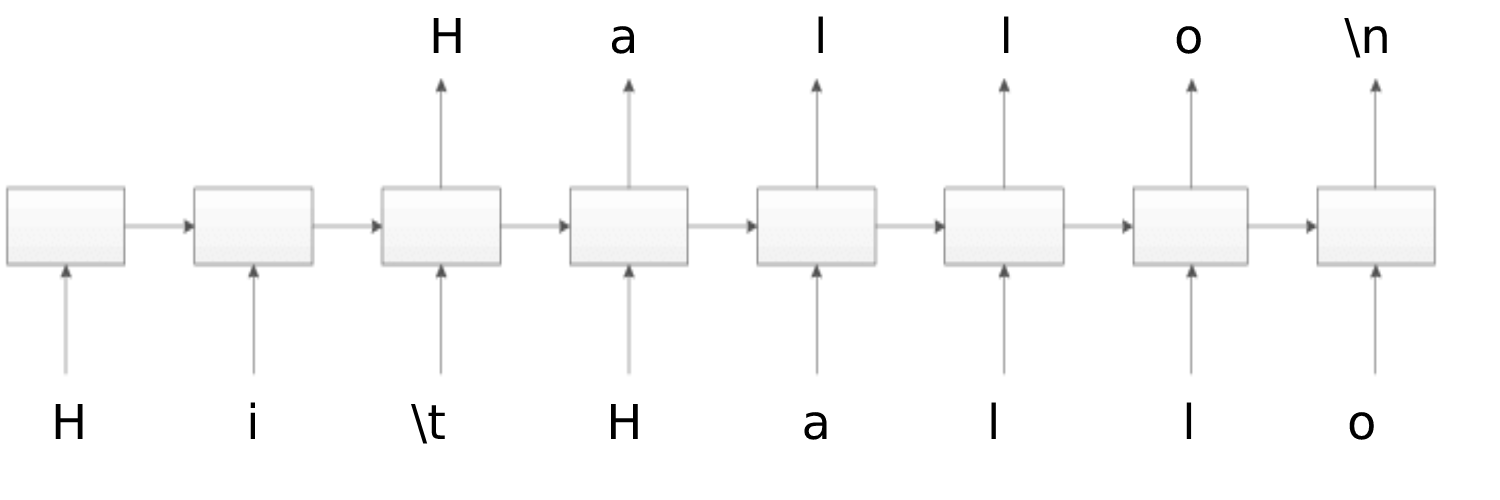

In [7]:
encoder_input_data = np.zeros(
    (m_train, max_encoder_seq_length, num_encoder_tokens), dtype="float32")
decoder_input_data = np.zeros(
    (m_train, max_decoder_seq_length, num_decoder_tokens), dtype="float32")
decoder_target_data = np.zeros(
    (m_train, max_decoder_seq_length, num_decoder_tokens), dtype="float32")

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_char2idx[char]] = 1.0
    # Padding the sequences with space characters.
    encoder_input_data[i, t + 1 :, input_char2idx[" "]] = 1.0
    for t, char in enumerate(target_text):
        if (t < len(target_text)-1):
            # decoder_input_data will not include the end of sequence character
            decoder_input_data[i, t, target_char2idx[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep and will not include the beginning of sequence character.
            decoder_target_data[i, t - 1, target_char2idx[char]] = 1.0
    # Padding the sequences with space characters.
    decoder_input_data[i, t:, target_char2idx[" "]] = 1.0
    decoder_target_data[i, t:, target_char2idx[" "]] = 1.0

## Building the model

In [8]:
HIDDEN_DIM = 256

# Encoder Sequence
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens), name="encoder_inputs")
encoder_lstm = keras.layers.LSTM(HIDDEN_DIM, return_state=True, name="encoder_lstm")
_, state_h, state_c = encoder_lstm(encoder_inputs)

# Discard the output and only keep the states.
encoder_states = [state_h, state_c]

# Decoder Sequence using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens), name="decoder_inputs")
decoder_lstm = keras.layers.LSTM(HIDDEN_DIM, return_sequences=True, return_state=True, name="decoder_lstm")
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax",  name="decoder_dense")
decoder_outputs = decoder_dense(decoder_outputs)

# Build the model that takes in `encoder_input_data` & `decoder_input_data` as input and gives `decoder_target_data` as output.
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs,  name="train_model")
model.summary()

Model: "train_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None, 70)]   0           []                               
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None, 86)]   0           []                               
                                                                                                  
 encoder_lstm (LSTM)            [(None, 256),        334848      ['encoder_inputs[0][0]']         
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                        

## Training the model

In [9]:
batch_size = 64
epochs = 100

In [11]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    [encoder_input_data, decoder_input_data], decoder_target_data, 
    batch_size=batch_size, epochs=epochs, validation_split=0.2)
print("Model created")

Epoch 1/100
125/125 [==============================] - 52s 388ms/step - loss: 1.3338 - accuracy: 0.6793 - val_loss: 1.2456 - val_accuracy: 0.6509
Epoch 2/100
125/125 [==============================] - 47s 374ms/step - loss: 0.9586 - accuracy: 0.7442 - val_loss: 0.9580 - val_accuracy: 0.7390
Epoch 3/100
125/125 [==============================] - 47s 372ms/step - loss: 0.7722 - accuracy: 0.7874 - val_loss: 0.8257 - val_accuracy: 0.7683
Epoch 4/100
125/125 [==============================] - 47s 374ms/step - loss: 0.6832 - accuracy: 0.8061 - val_loss: 0.7528 - val_accuracy: 0.7842
Epoch 5/100
125/125 [==============================] - 47s 377ms/step - loss: 0.6309 - accuracy: 0.8189 - val_loss: 0.7130 - val_accuracy: 0.7959
Epoch 6/100
125/125 [==============================] - 47s 380ms/step - loss: 0.5903 - accuracy: 0.8297 - val_loss: 0.6833 - val_accuracy: 0.8031
Epoch 7/100
125/125 [==============================] - 48s 388ms/step - loss: 0.5567 - accuracy: 0.8385 - val_loss: 0.6476 -

In [12]:
model.save(data_path + 'eng-deu-model.h5')

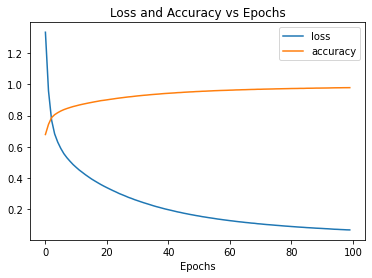

In [14]:
import pandas as pd
hist_df = pd.DataFrame(history.history)

plt = hist_df['loss'].plot(legend="Loss", title="Loss and Accuracy vs Epochs")
hist_df['accuracy'].plot(legend="Accuracy")
_ = plt.set_xlabel("Epochs")

## Inference

In [15]:
model = keras.models.load_model(data_path + 'eng-deu-model.h5')

encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states, name="encoder_model")

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(HIDDEN_DIM,), name="dec_state_h_input")
decoder_state_input_c = keras.Input(shape=(HIDDEN_DIM,), name="dec_state_c_input")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states, name="decoder_model")

encoder_model.summary()
decoder_model.summary()

Model: "encoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_inputs (InputLayer)  [(None, None, 70)]       0         
                                                                 
 encoder_lstm (LSTM)         [(None, 256),             334848    
                              (None, 256),                       
                              (None, 256)]                       
                                                                 
Total params: 334,848
Trainable params: 334,848
Non-trainable params: 0
_________________________________________________________________
Model: "decoder_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 decoder_inputs (InputLayer)    [(None, None, 86)]   0           []                       

In [16]:
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Fill the first character of target sequence with the beginning of sequence character.
    target_seq[0, 0, target_char2idx["\t"]] = 1.0

    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = target_idx2char[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length or find stop character.
        if (sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        states_value = [h, c]
    return decoded_sentence

In [19]:
for seq_index in range(20):
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)

Input sentence: Hi.
Decoded sentence: Hallo!

Input sentence: Hi.
Decoded sentence: Hallo!

Input sentence: Run!
Decoded sentence: Lauf!

Input sentence: Wow!
Decoded sentence: Potzdonner!

Input sentence: Wow!
Decoded sentence: Potzdonner!

Input sentence: Fire!
Decoded sentence: Feuer!

Input sentence: Help!
Decoded sentence: Hilfe!

Input sentence: Help!
Decoded sentence: Hilfe!

Input sentence: Stop!
Decoded sentence: Stopp!

Input sentence: Wait!
Decoded sentence: Warte!

Input sentence: Hello!
Decoded sentence: Hallo!

Input sentence: I try.
Decoded sentence: Ich probiere es.

Input sentence: I won!
Decoded sentence: Ich habe gewonnen!

Input sentence: I won!
Decoded sentence: Ich habe gewonnen!

Input sentence: Smile.
Decoded sentence: Lächeln!

Input sentence: Cheers!
Decoded sentence: Zum Wohl!

Input sentence: Freeze!
Decoded sentence: Keine Bewegung!

Input sentence: Freeze!
Decoded sentence: Keine Bewegung!

Input sentence: Got it?
Decoded sentence: Verstanden?

Input sente

In [20]:
def preprocess_user_input(user_input):
    user_input_len = len(user_input)
    if (user_input_len > max_encoder_seq_length):
        print("<The input has been truncated since it exceeds the maximum input length.>")
        user_input = user_input[: max_encoder_seq_length]
    elif (user_input_len < max_encoder_seq_length):
        user_input += (max_encoder_seq_length - user_input_len) * ' '
    input_seq = np.zeros(shape=(1, max_encoder_seq_length, num_encoder_tokens), dtype='float32')
    for i, char in enumerate(user_input):
        if (char in input_char2idx.keys()):
            input_seq[0, i, input_char2idx[char]] = 1.0
        else:
            print("<'{0}' is not in the input character list.>".format(char))
    return input_seq

In [23]:
user_input = input("Type the English sentence to be translated (Press '0' to exit)\nInput:\t")
bot_on = True
while bot_on:
  input_seq = preprocess_user_input(user_input)
  bot_output = decode_sequence(input_seq)
  user_input = input("Output:\t" + bot_output + "Input:\t")
  if user_input == "0":
    bot_on = False

Type the English sentence to be translated (Press '0' to exit)
Input:	Hi.
Output:	Hallo!
Input:	How are you?
Output:	Wie geht's dir?
Input:	I am fine.
Output:	Ich bin glücklich.
Input:	Are you happy?
Output:	Sind Sie glücklich?
Input:	Life is fun.
Output:	Das Leben macht Spaß.
Input:	Goodbye!
Output:	Auf Wiedersehen!
Input:	0
